In [1]:
import pandas as pd
from data_utils import ts_data_formulator, splitter, seed_all, normalize
import numpy as np
import torch

bike_data = pd.read_csv("Dataset/Bike-Sharing-Dataset/hour.csv", index_col = "instant")

bike_data_indep = bike_data.iloc[:, 2:13]

bike_data_dep = bike_data.iloc[:, 15:]

x = bike_data_indep.to_numpy()
y = bike_data_dep.to_numpy()

SEED = 1234

seed_all(SEED)

x_normed, x_normalizer = normalize(x)

x = x_normed

N_train = int(len(x) * 0.9)
N_test = int(len(x) * 0.1)

tr_idx = np.arange(len(x))[:N_train]

te_idx = np.arange(len(x))[N_train:N_train+N_test]


test_X, test_Y = ts_data_formulator(x[te_idx], y[te_idx])

test_Y = np.squeeze(test_Y, axis = 1)


x_reshaped, y_reshaped = ts_data_formulator(x[tr_idx], y[tr_idx])


N_model_train = int(len(y_reshaped) * 0.7)
N_recalibration = int(len(y_reshaped) * 0.3)

tr_new_idx, recal_idx = splitter(N_model_train, N_recalibration, seed = SEED)


recal_X = x_reshaped[recal_idx]
recal_Y = np.squeeze(y_reshaped[recal_idx], axis = 1)



x_remain, y_remain = x_reshaped[tr_new_idx], y_reshaped[tr_new_idx]


split = 0.8
train_idx, val_idx = splitter(int(split * len(y_remain)), len(y_remain) - int(split * len(y_remain)), seed = SEED)


train_X, train_Y = x_remain[train_idx], y_remain[train_idx]
val_X, val_Y = x_remain[val_idx], y_remain[val_idx]

n_feature = x.shape[1]

epochs = 300

COV_DIM = train_X.shape[2]
LSTM_HIDDEN_DIM = 40

train_X = torch.Tensor(train_X)
train_Y = torch.Tensor(train_Y).view(-1).cuda()
val_X = torch.Tensor(val_X)
val_Y = torch.Tensor(val_Y).view(-1).cuda()


In [8]:
bike_data_indep

,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
instant,,,,,,,,,,,
1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000
2,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000
3,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000
4,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000
5,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
17375,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642
17376,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642
17377,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642


## LSTM heteroskedastic

In [2]:
from src.LSTMmodels import Vanilla_LSTM
from src.losses import mse_loss, rmse_loss, mean_std_norm_loss
import torch



seed_all(SEED)


nll_model = Vanilla_LSTM(
    COV_DIM = COV_DIM,
    LSTM_HIDDEN_DIM = LSTM_HIDDEN_DIM,
    LSTM_LAYER = 2,
)

nll_model.train(
    train_X, train_Y, val_X, val_Y.view(-1),
    LR = 1E-2,
    N_Epoch = epochs,
    
    loss_criteria =  mean_std_norm_loss,
    val_loss_criterias = {
        "rmse": rmse_loss
    },
    
    early_stopping = True,
    patience = 50
)


torch.save(nll_model.state_dict(), "Experiments/EXP2/model_bin/TS_LSTM.pth")

TypeError: Cannot interpret '-1' as a data type

In [2]:
from src.LSTMmodels import Vanilla_LSTM
from src.losses import mse_loss, rmse_loss, mean_std_norm_loss
import torch



nll_model = Vanilla_LSTM(
    COV_DIM = COV_DIM,
    LSTM_HIDDEN_DIM = LSTM_HIDDEN_DIM,
    LSTM_LAYER = 2,
)

nll_model.load_state_dict(torch.load("Experiments/EXP2/model_bin/TS_LSTM.pth"))

<All keys matched successfully>

In [3]:
from src.losses import rmse_loss, mean_std_norm_loss

test_X = torch.Tensor(test_X).cuda()
test_Y = torch.Tensor(test_Y).view(-1).cuda()

te_err = rmse_loss(nll_model.predict(test_X), test_Y)

print("RMSE error: ", te_err.item())

RMSE error:  90.86510467529297


AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

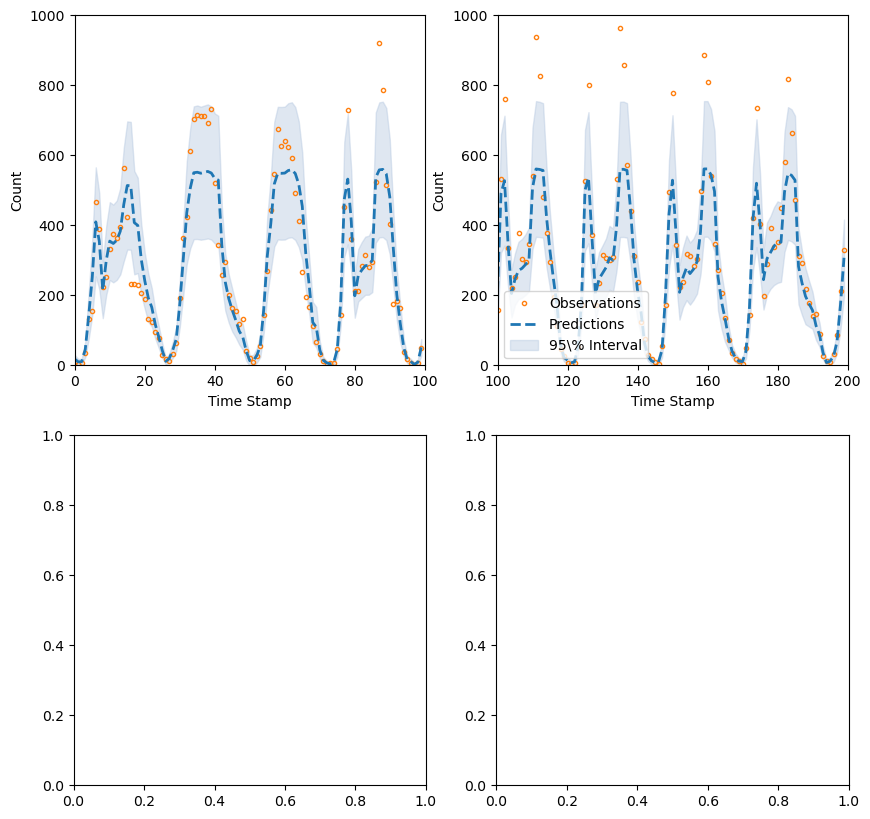

In [17]:
import matplotlib.pyplot as plt
from src.DEFAULTS import normalZ
from src.plot_utils import plot_xy_specifyBound

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax_up = ax[0]
ax1 = ax[0][0]
ax2 = ax[0][1]

ylims = [0, 1000]

sample_start1 = 0
sample_end1 = 100

sample_start2 = 100
sample_end2 = 200


preds1 = nll_model.predict(test_X[sample_start1:sample_end1]).detach().cpu().numpy()
preds2 = nll_model.predict(test_X[sample_start2:sample_end2]).detach().cpu().numpy()

pred_mean1 = preds1[:,0]
pred_sig1 = preds1[:,1]
pred_mean2 = preds2[:,0]
pred_sig2 = preds2[:,1]




y_test_UP1 = pred_mean1 + normalZ.ppf(0.975) * pred_sig1
y_test_LO1 = pred_mean1 + normalZ.ppf(0.025) * pred_sig1

y_test_UP2 = pred_mean2 + normalZ.ppf(0.975) * pred_sig2
y_test_LO2 = pred_mean2 + normalZ.ppf(0.025) * pred_sig2



# Make xy plot
ax1 = plot_xy_specifyBound(
    pred_mean1, y_test_UP1, y_test_LO1, 
    test_Y.cpu().numpy()[sample_start1:sample_end1], 
    np.arange(sample_start1, sample_end1), n_subset = None, ylims=ylims, xlims=[sample_start1, sample_end1], ax=ax1,
    dashStyle = True,
    legend=False,
    x_label = "Time Stamp",
    y_label = "Count",
    title = ""
)

ax2 = plot_xy_specifyBound(
    pred_mean2, y_test_UP2, y_test_LO2, 
    test_Y.cpu().numpy()[sample_start2:sample_end2], 
    np.arange(sample_start2, sample_end2), n_subset = None, ylims=ylims, xlims=[sample_start2, sample_end2], ax=ax2,
    dashStyle = True,
    x_label = "Time Stamp",
    y_label = "Count",
    title = ""
)

ax[0].set_title("HNN-LSTM")

fig.show()

# LSTM with kernel and random projection

In [37]:
mse_model = Vanilla_LSTM(
    COV_DIM = COV_DIM,
    LSTM_HIDDEN_DIM = LSTM_HIDDEN_DIM,
    LSTM_LAYER = 2,
    output_scheme = "pred"
)

mse_model.train(
    train_X, train_Y, val_X, val_Y,
    LR = 5E-3,
    N_Epoch = epochs,
    
    early_stopping = True,
    patience = 30
)

torch.save(mse_model.state_dict(), "Experiments/EXP2/model_bin/TS_LSTM_pred.pth")

epoch  0
     loss: rmse, 225.57171630859375
epoch  15
     loss: rmse, 98.5696792602539
epoch  30
     loss: rmse, 61.924560546875
epoch  45
     loss: rmse, 49.20547103881836
epoch  60
     loss: rmse, 40.87557601928711
epoch  75
     loss: rmse, 38.51313018798828
epoch  90
     loss: rmse, 40.0315055847168
Early Stopped at Epoch  105


In [4]:
mse_model = Vanilla_LSTM(
    COV_DIM = COV_DIM,
    LSTM_HIDDEN_DIM = LSTM_HIDDEN_DIM,
    LSTM_LAYER = 2,
    output_scheme = "pred"
)

mse_model.load_state_dict(torch.load("Experiments/EXP2/model_bin/TS_LSTM_pred.pth"))

<All keys matched successfully>

In [5]:
mse_te_err = rmse_loss(mse_model.predict(test_X), test_Y)

print("RMSE error: ", mse_te_err.item())

RMSE error:  85.10746002197266


C:\Users\16065\AppData\Local\Temp\ipykernel_17696\834004595.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


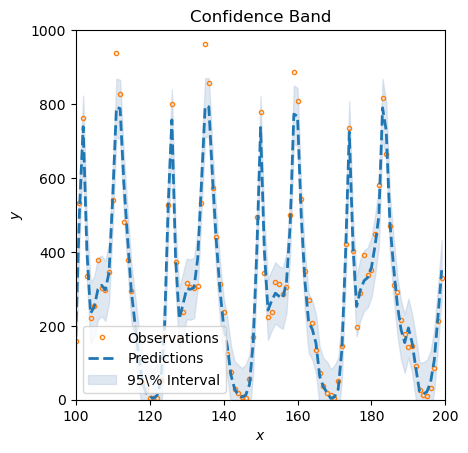

In [9]:
from sklearn import random_projection
from src.kernel_methods import kernel_estimator


recal_X = torch.Tensor(recal_X).cuda()
recal_Y = torch.Tensor(recal_Y).view(-1).cuda()


fig, ax = plt.subplots()

ylims = [0, 1000]

sample_start = 100
sample_end = 200

sub_testX = test_X[sample_start:sample_end]

n_component = 4
wid = 10

transformer = random_projection.GaussianRandomProjection(n_components = n_component)

reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

recal_mean = mse_model.predict(recal_X).view(-1)
test_mean = mse_model.predict(sub_testX).view(-1)

test_Z =  reformer(sub_testX.reshape(len(sub_testX), -1))
recal_Z = reformer(recal_X.reshape(len(recal_X), -1))


eps_diffQuants = kernel_estimator(
    test_Z = test_Z.cuda(),
    recal_Z = recal_Z.cuda(),
    recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
    quants = [0.025, 0.975],
    wid= wid
)

y_diffQuants = eps_diffQuants + test_mean.view(1,-1).repeat(len(eps_diffQuants),1)

y_test_UP = y_diffQuants[0].detach().cpu().numpy()
y_test_LO = y_diffQuants[1].detach().cpu().numpy()



# Make xy plot
axs = plot_xy_specifyBound(
    test_mean.detach().cpu().numpy(), y_test_UP, y_test_LO, 
    test_Y[sample_start:sample_end].cpu().numpy(), 
    np.arange(sample_start, sample_end), n_subset = None, ylims=ylims, xlims=[sample_start, sample_end], ax=ax,
    dashStyle = True
)

fig.show()

# If we don't random project

C:\Users\16065\AppData\Local\Temp\ipykernel_2340\3325862165.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


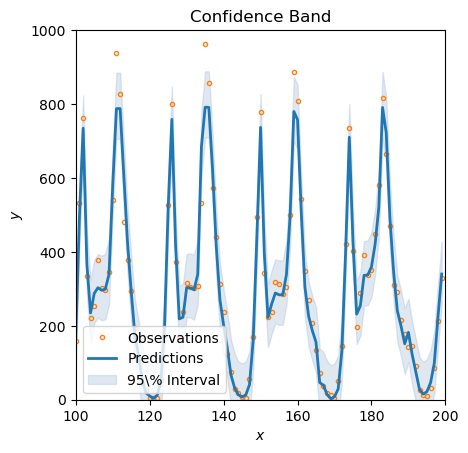

In [64]:
fig, ax = plt.subplots()

ylims = [0, 1000]

sample_start = 100
sample_end = 200

sub_testX = test_X[sample_start:sample_end]

wid = 10

recal_mean = mse_model.predict(recal_X).view(-1)
test_mean = mse_model.predict(sub_testX).view(-1)


eps_diffQuants = kernel_estimator(
    test_Z = sub_testX.reshape(len(sub_testX), -1).cuda(),
    recal_Z = recal_X.reshape(len(recal_X), -1).cuda(),
    recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
    quants = [0.025, 0.975],
    wid= wid
)

y_diffQuants = eps_diffQuants + test_mean.view(1,-1).repeat(len(eps_diffQuants),1)

y_test_UP = y_diffQuants[0].detach().cpu().numpy()
y_test_LO = y_diffQuants[1].detach().cpu().numpy()



# Make xy plot
axs = plot_xy_specifyBound(
    test_mean.detach().cpu().numpy(), y_test_UP, y_test_LO, test_Y.cpu().numpy()[sample_start:sample_end], np.arange(sample_start, sample_end), n_subset = None, ylims=ylims, xlims=[sample_start, sample_end], ax=ax
)

fig.show()

Text(0.5, 1.0, 'LSTM-Kernel-RP')

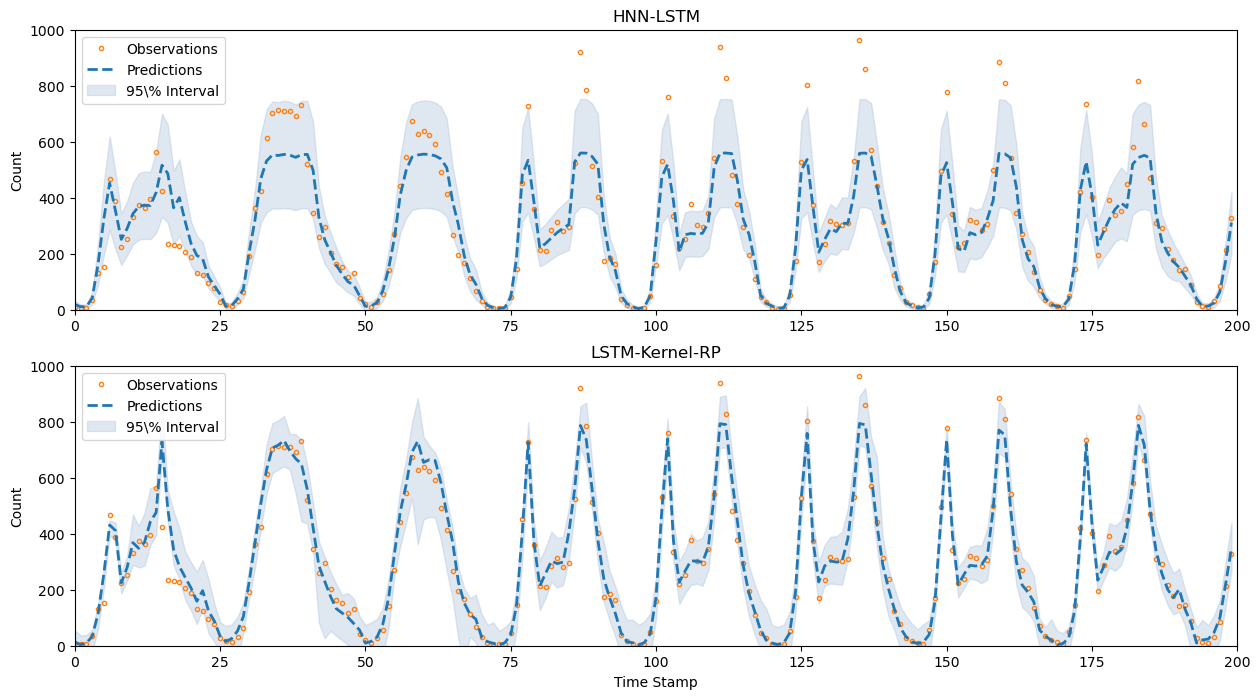

In [12]:
from sklearn import random_projection
from src.kernel_methods import kernel_estimator
import matplotlib.pyplot as plt
from src.DEFAULTS import normalZ
from src.plot_utils import plot_xy_specifyBound



# create 2x1 subfigs

fig, ax = plt.subplots(2, 1, figsize = (15, 8))

ylims = [0, 1000]

sample_start1 = 0
sample_end1 = 200

preds1 = nll_model.predict(test_X[sample_start1:sample_end1]).detach().cpu().numpy()
        
pred_mean1 = preds1[:,0]
pred_sig1 = preds1[:,1]
        
y_test_UP1 = pred_mean1 + normalZ.ppf(0.975) * pred_sig1
y_test_LO1 = pred_mean1 + normalZ.ppf(0.025) * pred_sig1


ax1 = ax[0]


ax1 = plot_xy_specifyBound(
            pred_mean1, y_test_UP1, y_test_LO1, 
            test_Y.cpu().numpy()[sample_start1:sample_end1], 
            np.arange(sample_start1, sample_end1), n_subset = None, 
            ylims=ylims, xlims=[sample_start1, sample_end1], 
            ax=ax1,
            dashStyle = True,
            legend=True,
            x_label = "",
            y_label = "Count",
            title = "",
            leg_loc = "upper left"
        )

ax1.set_title("HNN-LSTM")


recal_X = torch.Tensor(recal_X).cuda()
recal_Y = torch.Tensor(recal_Y).view(-1).cuda()


        
sample_start3 = 0
sample_end3 = 200
        

sub_testX3 = test_X[sample_start3:sample_end3]
        
n_component = 4
wid = 2

transformer = random_projection.GaussianRandomProjection(n_components = n_component)

reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

recal_mean = mse_model.predict(recal_X).view(-1)
test_mean3 = mse_model.predict(sub_testX3).view(-1)

test_Z3 =  reformer(sub_testX3.reshape(len(sub_testX3), -1))
recal_Z = reformer(recal_X.reshape(len(recal_X), -1))


eps_diffQuants3 = kernel_estimator(
    test_Z = test_Z3.cuda(),
    recal_Z = recal_Z.cuda(),
    recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
    quants = [0.025, 0.975],
    wid= wid
)


y_diffQuants3 = eps_diffQuants3 + test_mean3.view(1,-1).repeat(len(eps_diffQuants3),1)

y_test_LO3 = y_diffQuants3[0].detach().cpu().numpy()
y_test_UP3 = y_diffQuants3[1].detach().cpu().numpy()
       
ax3 = ax[1]
        
axs3 = plot_xy_specifyBound(
    test_mean3.detach().cpu().numpy(), y_test_UP3, y_test_LO3, 
    test_Y[sample_start3:sample_end3].cpu().numpy(), 
    np.arange(sample_start3, sample_end3), n_subset = None, 
    ylims=ylims, xlims=[sample_start3, sample_end3], 
    ax=ax3,
    dashStyle = True,
    legend = True,
    x_label = "Time Stamp",
    y_label = "Count",
    title = "",
    leg_loc = "upper left"
)


ax3.set_title("LSTM-Kernel-RP")


   

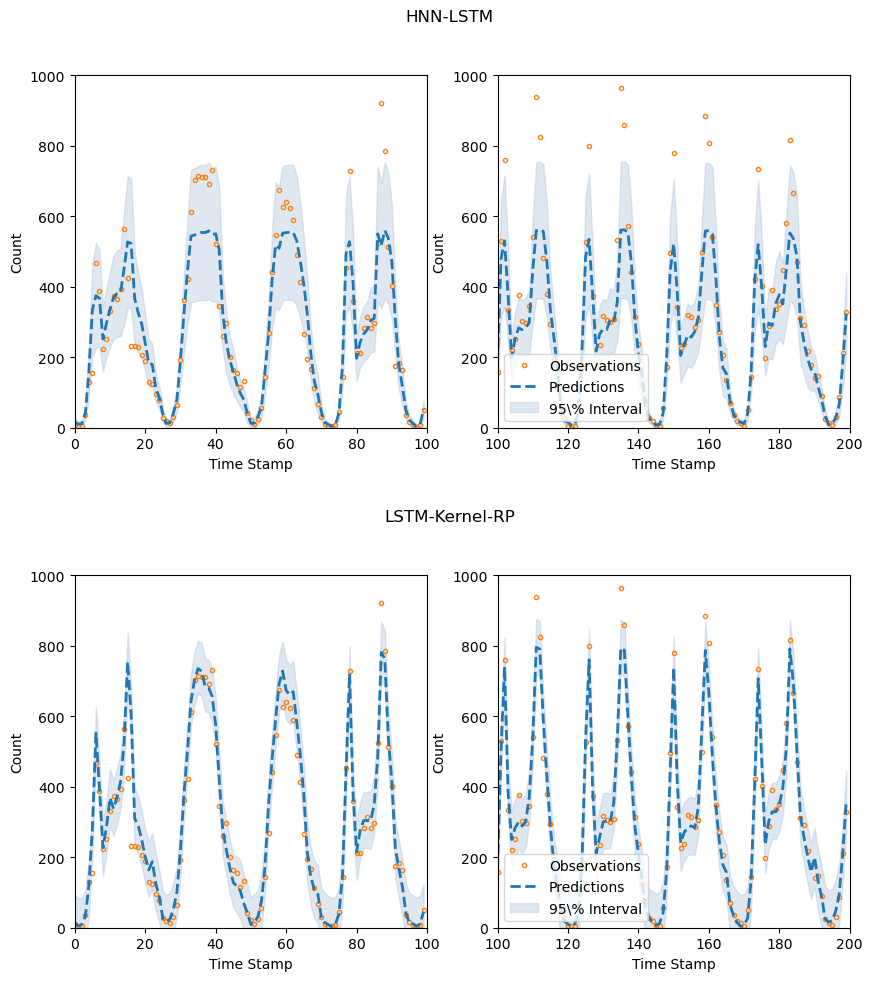

In [50]:
from sklearn import random_projection
from src.kernel_methods import kernel_estimator
import matplotlib.pyplot as plt
from src.DEFAULTS import normalZ
from src.plot_utils import plot_xy_specifyBound


fig = plt.figure(figsize=(10, 10))
plt.tight_layout()
fig.suptitle('Bike-Sharing Rental Count')

# create 2x1 subfigs

subfigs = fig.subfigures(nrows=2, ncols=1)

for row, subfig in enumerate(subfigs):
    
    if row == 0:
        
        subfig1 = subfig

        # HNN-LSTM
        subfig1.suptitle("HNN-LSTM")


        ax = subfig1.subplots(nrows=1, ncols=2)
        
        for ct, axi in enumerate(ax):
            
            if ct == 0:
                ax1 = axi
                
            elif ct == 1:
                
                ax2 = axi


        ylims = [0, 1000]

        sample_start1 = 0
        sample_end1 = 100

        sample_start2 = 100
        sample_end2 = 200


        preds1 = nll_model.predict(test_X[sample_start1:sample_end1]).detach().cpu().numpy()
        preds2 = nll_model.predict(test_X[sample_start2:sample_end2]).detach().cpu().numpy()

        pred_mean1 = preds1[:,0]
        pred_sig1 = preds1[:,1]
        pred_mean2 = preds2[:,0]
        pred_sig2 = preds2[:,1]




        y_test_UP1 = pred_mean1 + normalZ.ppf(0.975) * pred_sig1
        y_test_LO1 = pred_mean1 + normalZ.ppf(0.025) * pred_sig1

        y_test_UP2 = pred_mean2 + normalZ.ppf(0.975) * pred_sig2
        y_test_LO2 = pred_mean2 + normalZ.ppf(0.025) * pred_sig2

        ax1 = plot_xy_specifyBound(
            pred_mean1, y_test_UP1, y_test_LO1, 
            test_Y.cpu().numpy()[sample_start1:sample_end1], 
            np.arange(sample_start1, sample_end1), n_subset = None, ylims=ylims, xlims=[sample_start1, sample_end1], ax=ax1,
            dashStyle = True,
            legend=False,
            x_label = "Time Stamp",
            y_label = "Count",
            title = ""
        )

        ax2 = plot_xy_specifyBound(
            pred_mean2, y_test_UP2, y_test_LO2, 
            test_Y.cpu().numpy()[sample_start2:sample_end2], 
            np.arange(sample_start2, sample_end2), n_subset = None, ylims=ylims, xlims=[sample_start2, sample_end2], ax=ax2,
            dashStyle = True,
            x_label = "Time Stamp",
            y_label = "Count",
            title = ""
        )
        
    elif row == 1:
        
        subfig2 = subfig
        



        # LSTM-Kernel-RP
        subfig2.suptitle("LSTM-Kernel-RP")




        recal_X = torch.Tensor(recal_X).cuda()
        recal_Y = torch.Tensor(recal_Y).view(-1).cuda()


        ax = subfig2.subplots(1,2)
        
        for ct, axi in enumerate(ax):
            if ct == 0:
                ax3 = axi
            elif ct == 1:
                ax4 = axi

        ylims = [0, 1000]

        sample_start3 = 0
        sample_end3 = 100
        sample_start4 = 100
        sample_end4 = 200

        sub_testX3 = test_X[sample_start3:sample_end3]
        sub_testX4 = test_X[sample_start4:sample_end4]

        n_component = 4
        wid = 10

        transformer = random_projection.GaussianRandomProjection(n_components = n_component)

        reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

        recal_mean = mse_model.predict(recal_X).view(-1)
        test_mean3 = mse_model.predict(sub_testX3).view(-1)
        test_mean4 = mse_model.predict(sub_testX4).view(-1)

        test_Z3 =  reformer(sub_testX3.reshape(len(sub_testX3), -1))
        test_Z4 =  reformer(sub_testX4.reshape(len(sub_testX4), -1))
        recal_Z = reformer(recal_X.reshape(len(recal_X), -1))


        eps_diffQuants3 = kernel_estimator(
            test_Z = test_Z3.cuda(),
            recal_Z = recal_Z.cuda(),
            recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
            quants = [0.025, 0.975],
            wid= wid
        )
        eps_diffQuants4 = kernel_estimator(
            test_Z = test_Z4.cuda(),
            recal_Z = recal_Z.cuda(),
            recal_epsilon = torch.Tensor(recal_Y - recal_mean).cuda(),
            quants = [0.025, 0.975],
            wid= wid
        )


        y_diffQuants3 = eps_diffQuants3 + test_mean3.view(1,-1).repeat(len(eps_diffQuants3),1)
        y_diffQuants4 = eps_diffQuants4 + test_mean4.view(1,-1).repeat(len(eps_diffQuants4),1)

        y_test_LO3 = y_diffQuants3[0].detach().cpu().numpy()
        y_test_UP3 = y_diffQuants3[1].detach().cpu().numpy()
        y_test_LO4 = y_diffQuants4[0].detach().cpu().numpy()
        y_test_UP4 = y_diffQuants4[1].detach().cpu().numpy()


        # Make xy plot
        axs3 = plot_xy_specifyBound(
            test_mean3.detach().cpu().numpy(), y_test_UP3, y_test_LO3, 
            test_Y[sample_start3:sample_end3].cpu().numpy(), 
            np.arange(sample_start3, sample_end3), n_subset = None, ylims=ylims, xlims=[sample_start3, sample_end3], ax=ax3,
            dashStyle = True,
            legend = False,
            x_label = "Time Stamp",
            y_label = "Count",
            title = ""
        )

        axs4 = plot_xy_specifyBound(
            test_mean4.detach().cpu().numpy(), y_test_UP4, y_test_LO4, 
            test_Y[sample_start4:sample_end4].cpu().numpy(), 
            np.arange(sample_start4, sample_end4), n_subset = None, ylims=ylims, xlims=[sample_start4, sample_end4], ax=ax4,
            dashStyle = True,
            x_label = "Time Stamp",
            y_label = "Count",
            title = ""
        )



   